$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\bb}[1]{\bm{\mathrm{#1}}}
$$

# Part 3: Generative Adversarial Networks
<a id=part3></a>

In this part we will implement and train a generative adversarial network and apply it to the task of image generation.

In [1]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Obtaining the dataset
<a id=part3_1></a>

We'll use the same data as in Part 2.

But again, to use a custom dataset, edit the `PART3_CUSTOM_DATA_URL` variable in `hw3/answers.py`.

In [2]:
import cs236605.plot as plot
import cs236605.download
from hw3.answers import PART3_CUSTOM_DATA_URL as CUSTOM_DATA_URL

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')
if CUSTOM_DATA_URL is None:
    DATA_URL = 'http://vis-www.cs.umass.edu/lfw/lfw-bush.zip'
else:
    DATA_URL = CUSTOM_DATA_URL

_, dataset_dir = cs236605.download.download_data(out_path=DATA_DIR, url=DATA_URL, extract=True, force=False)

File /home/thaer/.pytorch-datasets/lfw-bush.zip exists, skipping download.
Extracting /home/thaer/.pytorch-datasets/lfw-bush.zip...
Extracted 531 to /home/thaer/.pytorch-datasets/lfw/George_W_Bush


Create a `Dataset` object that will load the extraced images:

In [22]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

im_size = 64
tf = T.Compose([
    # Resize to constant spatial dimensions
    T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])

ds_gwb = ImageFolder(os.path.dirname(dataset_dir), tf)

OK, let's see what we got. You can run the following block multiple times to display a random subset of images from the dataset.

Found 530 images in dataset folder.


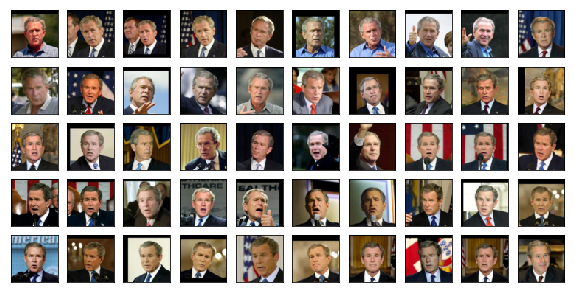

In [23]:
_ = plot.dataset_first_n(ds_gwb, 50, figsize=(10,5), nrows=5)
print(f'Found {len(ds_gwb)} images in dataset folder.')

In [24]:
x0, y0 = ds_gwb[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

test.assertSequenceEqual(x0.shape, (1, 3, im_size, im_size))

torch.Size([1, 3, 64, 64])


## Generative Adversarial Nets (GANs)
<a id=part3_2></a>

GANs, first proposed in a [paper](https://arxiv.org/pdf/1406.2661.pdf) by Ian Goodfellow in 2014 are today arguably the most popular type of generative model. GANs are currently producing state of the art
results in generative tasks over many different domains.

In a GAN model, two different neural networks compete against each other: A **generator** and a **discriminator**.

- The Generator, which we'll denote as $\Psi _{\bb{\gamma}} : \mathcal{U} \rightarrow \mathcal{X}$, maps a latent-space variable
$\bb{u}\sim\mathcal{N}(\bb{0},\bb{I})$ to an instance-space variable $\bb{x}$ (e.g. an image).
Thus a parametric evidence distribution $p_{\bb{\gamma}}(\bb{X})$ is generated,
which we typically would like to be as close as possible to the real evidence distribution, $p(\bb{X})$.

- The Discriminator, $\Delta _{\bb{\delta}} : \mathcal{X} \rightarrow [0,1]$, is a network which,
given an instance-space variable $\bb{x}$, returns the  probability that $\bb{x}$ is real, i.e. that $\bb{x}$
was sampled from $p(\bb{X})$ and not $p_{\bb{\gamma}}(\bb{X})$.


<img src="imgs/gan.jpg" />

### Training GANs
<a id=part3_3></a>

The generator is trained to generate "fake" instances which will maximally fool the
discriminator into returning that they're real. Mathematically, the generator's parameters
$\bb{\gamma}$ should be chosen such as to **maximize** the expression
$$
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

The discriminator is trained to classify between real images, coming from the training set,
and fake images generated by the generator.
Mathematically, the discriminator's parameters $\bb{\delta}$ should be chosen such as to
**maximize** the expression
$$
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

These two competing objectives can thus be expressed as the following min-max optimization:
$$
\min _{\bb{\gamma}} \max _{\bb{\delta}} \,
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

A key insight into GANs is that we can interpret the above maximum as the loss with respect to
$\bb{\gamma}$:

$$
L({\bb{\gamma}}) =
\max _{\bb{\delta}} \, \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
  \mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

This means that the generator's loss function trains together with the generator
itself in an adversarial manner. In contrast, when training our VAE we used a fixed L2 norm
as a data loss term.

### Model Implementation
<a id=part3_4></a>

We'll now implement a Deep Convolutional GAN (DCGAN) model.
See the DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) for architecture ideas and tips for training.

**TODO**: Implement the `Discriminator` class in the `hw3/gan.py` module.
If you wish you can reuse the `EncoderCNN` class from the VAE model as the first part of the Discriminator.

In [25]:
import hw3.gan as gan

dsc = gan.Discriminator(in_size=x0[0].shape).to(device)
print(dsc)

d0 = dsc(x0)
print(d0.shape)

test.assertSequenceEqual(d0.shape, (1,1))

torch.Size([3, 64, 64])
Discriminator(
  (discriminator): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)
torch.Size([1, 1])


**TODO**: Implement the `Generator` class in the `hw3/gan.py` module.
If you wish you can reuse the `DecoderCNN` class from the VAE model as the last part of the Generator.

In [26]:
z_dim = 128
gen = gan.Generator(z_dim, 4).to(device)
print(gen)

z = torch.randn(1, z_dim).to(device)
xr = gen(z)
print(xr.shape)

test.assertSequenceEqual(x0.shape, xr.shape)

Generator(
  (generator): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)
torch.Size([1, 

### Loss Implementation
<a id=part3_5></a>

Let's begin with the discriminator's loss function.
Based on the above we can flip the sign and say we want to update the 
Discriminator's parameters $\bb{\delta}$ so that they **minimize** the expression
$$
- \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, - \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

We're using the Discriminator twice in this expression;
once to classify data from the real data distribution and
once again to classify generated data.
Therefore our loss should be computed based on these two terms.
Notice that since the discriminator returns a probability, we can formulate the above as two cross-entropy losses.

GANs are notoriously diffucult to train.
One common trick for improving GAN stability during training is to make the classification labels noisy for the discriminator. This can be seen as a form of regularization, to help prevent the discriminator from overfitting.

We'll incorporate this idea into our loss function. Instead of labels being equal to 0 or 1, we'll make them
"fuzzy", i.e. random numbers in the ranges $[0\pm\epsilon]$ and $[1\pm\epsilon]$.

**TODO**: Implement the `discriminator_loss_fn()` function in the `hw3/gan.py` module.

In [27]:
from hw3.gan import discriminator_loss_fn
torch.manual_seed(42)

y_data = torch.rand(10) * 10
y_generated = torch.rand(10) * 10

loss = discriminator_loss_fn(y_data, y_generated, data_label=1, label_noise=0.3)
print(loss)

test.assertAlmostEqual(loss.item(), 6.4808731, delta=1e-5)

tensor(6.4809)


Similarly, the generator's parameters $\bb{\gamma}$ should **minimize** the expression
$$
-\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) ))
$$

which can also be seen as a cross-entropy term.

**TODO**: Implement the `generator_loss_fn()` function in the `hw3/gan.py` module.

In [28]:
from hw3.gan import generator_loss_fn
torch.manual_seed(42)

y_generated = torch.rand(20) * 10

loss = generator_loss_fn(y_generated, data_label=1)
print(loss)

test.assertAlmostEqual(loss.item(), 0.0222969, delta=1e-3)

tensor(0.0223)


### Sampling
<a id=part3_6></a>

Sampling from a GAN is straightforward, since it learns to generate data from an isotropic Gaussian latent space distribution.

There is an important nuance however. Sampling is required during the process of training the GAN, since
we generate fake images to show the discriminator.
As you'll seen in the next section,  in some cases we'll need our samples to have gradients (i.e., to be part of
the Generator's computation graph).

**TODO**: Implement the `sample()` method in the `Generator` class within the `hw3/gan.py` module.

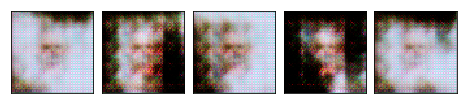

In [33]:
samples = gen.sample(5, with_grad=False)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNone(samples.grad_fn)
_ = plot.tensors_as_images(samples.cpu())

samples = gen.sample(5, with_grad=True)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNotNone(samples.grad_fn)

### Training
<a id=part3_7></a>

Training GANs is a bit different since we need to train two models simultaneously, each with it's own separate loss function and optimizer. We'll implement the training logic as a function that handles one batch of data
and updates both the discriminator and the generator based on it.

As mentioned above, GANs are considered hard to train. To get some ideas and tips you can see this [paper](https://arxiv.org/pdf/1606.03498.pdf), this list of ["GAN hacks"](https://github.com/soumith/ganhacks) or just do it the hard way :)

**TODO**:
1. Implement the `train_batch` function in the `hw3/gan.py` module.
2. Tweak the hyperparameters in the `part3_gan_hyperparam()` function within the `hw3/answers.py` module.

In [42]:
import torch.optim as optim
from torch.utils.data import DataLoader
from hw3.answers import part3_gan_hyperparams

torch.manual_seed(42)

# Hyperparams
hp = part3_gan_hyperparams()
batch_size = hp['batch_size']
z_dim = hp['z_dim']

# Data
dl_train = DataLoader(ds_gwb, batch_size, shuffle=True)
im_size = ds_gwb[0][0].shape

# Model
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)
dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_generated):
    return gan.discriminator_loss_fn(y_data, y_generated, hp['data_label'], hp['label_noise'])

def gen_loss_fn(y_generated):
    return gan.generator_loss_fn(y_generated, hp['data_label'])

# Training
checkpoint_file = 'checkpoints/gan'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hp)

torch.Size([3, 64, 64])
{'batch_size': 32, 'z_dim': 128, 'data_label': 1, 'label_noise': 0.1, 'discriminator_optimizer': {'type': 'Adam', 'lr': 0.0002}, 'generator_optimizer': {'type': 'Adam', 'lr': 0.0002}}


**TODO**:
1. Run the following block to train. It will sample some images from your model every few epochs so you can see the progress.
2. When you're satisfied with your results, rename the checkpoints file by adding `_final`. When you run the `main.py` script to generate your submission, the final checkpoints file will be loaded instead of running training.

--- EPOCH 1/100 ---
100%|██████████| 17/17 [00:02<00:00,  5.98it/s]
Discriminator loss: 0.3997996317989686
Generator loss:     3.6970504031461826


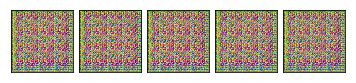

--- EPOCH 2/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.07it/s]
Discriminator loss: 0.05744442825808244
Generator loss:     6.382590939016903


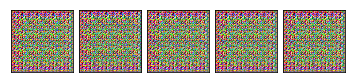

--- EPOCH 3/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.29it/s]
Discriminator loss: 0.03499809707350591
Generator loss:     7.407466635984533


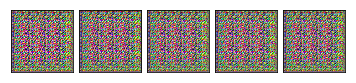

--- EPOCH 4/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.81it/s]
Discriminator loss: 0.02545465068782077
Generator loss:     8.222723512088551


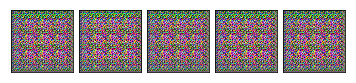

--- EPOCH 5/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.18it/s]
Discriminator loss: 0.027496620355283514
Generator loss:     7.665997224695542


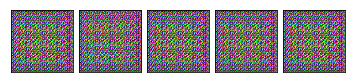

--- EPOCH 6/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.19it/s]
Discriminator loss: 0.03551900112891898
Generator loss:     8.622925365672392


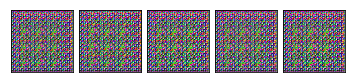

--- EPOCH 7/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.17it/s]
Discriminator loss: 0.017041409936021355
Generator loss:     7.828757426318


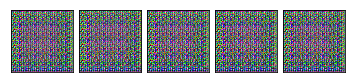

--- EPOCH 8/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.11it/s]
Discriminator loss: 0.017330769394688746
Generator loss:     9.04990016712862


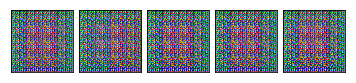

--- EPOCH 9/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.12it/s]
Discriminator loss: 0.008369593114099082
Generator loss:     11.117908225340003


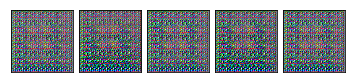

--- EPOCH 10/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.05it/s]
Discriminator loss: -0.008164972121662954
Generator loss:     8.850646439720602


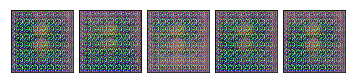

--- EPOCH 11/100 ---
100%|██████████| 17/17 [00:02<00:00,  4.80it/s]
Discriminator loss: 0.03359029535204172
Generator loss:     8.387451059678021


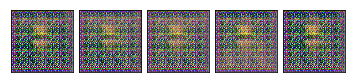

--- EPOCH 12/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.89it/s]
Discriminator loss: 0.029526890748563933
Generator loss:     8.835686908048743


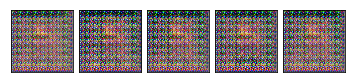

--- EPOCH 13/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.42it/s]
Discriminator loss: -0.02680584235007272
Generator loss:     8.748220331528607


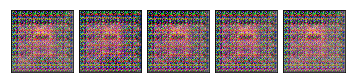

--- EPOCH 14/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.06it/s]
Discriminator loss: -0.023194397087482846
Generator loss:     9.40753173828125


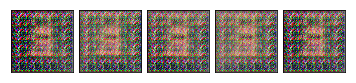

--- EPOCH 15/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.05it/s]
Discriminator loss: 0.042234193204956895
Generator loss:     9.920308253344368


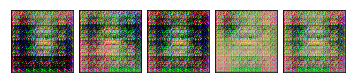

--- EPOCH 16/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.48it/s]
Discriminator loss: 0.06977200245156008
Generator loss:     9.612990912269144


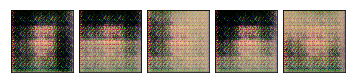

--- EPOCH 17/100 ---
100%|██████████| 17/17 [00:03<00:00,  5.46it/s]
Discriminator loss: 0.11978911071577493
Generator loss:     8.56616241791669


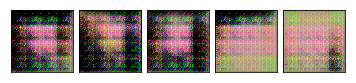

--- EPOCH 18/100 ---
100%|██████████| 17/17 [00:03<00:00,  5.49it/s]
Discriminator loss: 0.031767689568154955
Generator loss:     7.859900586745319


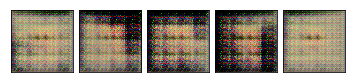

--- EPOCH 19/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.31it/s]
Discriminator loss: 0.05017274585278595
Generator loss:     8.538885817808264


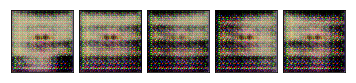

--- EPOCH 20/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.29it/s]
Discriminator loss: 0.06108879873200374
Generator loss:     8.080719218534583


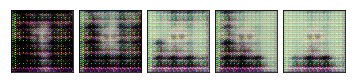

--- EPOCH 21/100 ---
100%|██████████| 17/17 [00:02<00:00,  5.85it/s]
Discriminator loss: 0.043207907391821634
Generator loss:     9.540590117959415


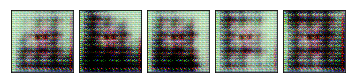

--- EPOCH 22/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.00it/s]
Discriminator loss: 0.09710065494565402
Generator loss:     8.890465652241426


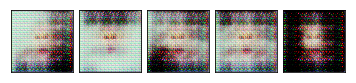

--- EPOCH 23/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.02it/s]
Discriminator loss: 0.05012296173064148
Generator loss:     8.016266093534583


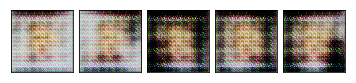

--- EPOCH 24/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.31it/s]
Discriminator loss: 0.05149577048552387
Generator loss:     9.516626273884492


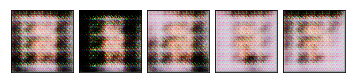

--- EPOCH 25/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.89it/s]
Discriminator loss: 0.058482547893243676
Generator loss:     7.993780865388758


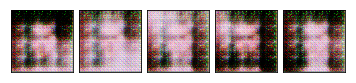

--- EPOCH 26/100 ---
100%|██████████| 17/17 [00:02<00:00,  4.98it/s]
Discriminator loss: 0.06915692492004703
Generator loss:     8.276343177346622


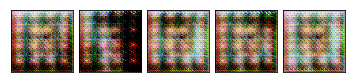

--- EPOCH 27/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.80it/s]
Discriminator loss: 0.05261469774824731
Generator loss:     9.442203521728516


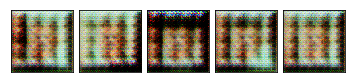

--- EPOCH 28/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.00it/s]
Discriminator loss: 0.01507603919462246
Generator loss:     7.253328211167279


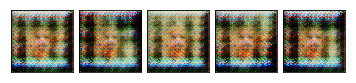

--- EPOCH 29/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.31it/s]
Discriminator loss: 0.00749248348395614
Generator loss:     8.046495072981891


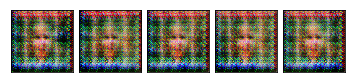

--- EPOCH 30/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.89it/s]
Discriminator loss: 0.07439230985062964
Generator loss:     10.804367850808536


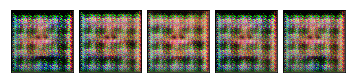

--- EPOCH 31/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.88it/s]
Discriminator loss: 0.058807927238590574
Generator loss:     8.387175251455869


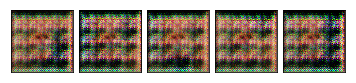

--- EPOCH 32/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.82it/s]
Discriminator loss: 0.02951432764530182
Generator loss:     7.27663516998291


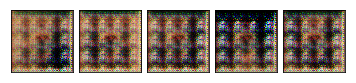

--- EPOCH 33/100 ---
100%|██████████| 17/17 [00:02<00:00,  5.78it/s]
Discriminator loss: 0.054750862490276206
Generator loss:     8.544525679420023


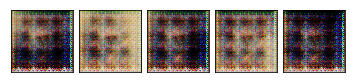

--- EPOCH 34/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.90it/s]
Discriminator loss: -0.006097479449475513
Generator loss:     6.879350297591266


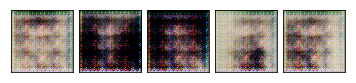

--- EPOCH 35/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.96it/s]
Discriminator loss: 0.04307999593370101
Generator loss:     7.981774554533117


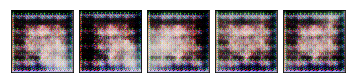

--- EPOCH 36/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.37it/s]
Discriminator loss: 0.06725204111460377
Generator loss:     8.098147139829749


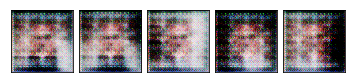

--- EPOCH 37/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.95it/s]
Discriminator loss: 0.08236251650925945
Generator loss:     8.583939720602597


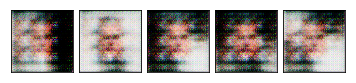

--- EPOCH 38/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.98it/s]
Discriminator loss: 0.11660962825750604
Generator loss:     9.72718365052167


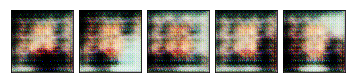

--- EPOCH 39/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.00it/s]
Discriminator loss: 0.06567833002875834
Generator loss:     9.160658079035143


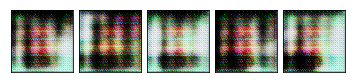

--- EPOCH 40/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.30it/s]
Discriminator loss: 0.05489360694499577
Generator loss:     9.161923576803769


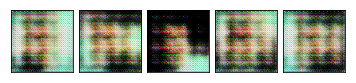

--- EPOCH 41/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.96it/s]
Discriminator loss: 0.15675586341496775
Generator loss:     9.673711075502283


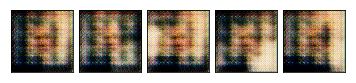

--- EPOCH 42/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.47it/s]
Discriminator loss: 0.08037909514763776
Generator loss:     9.897381894728717


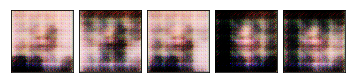

--- EPOCH 43/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.93it/s]
Discriminator loss: 0.1423093709437286
Generator loss:     8.750924082363353


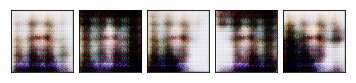

--- EPOCH 44/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.96it/s]
Discriminator loss: 0.04005306937238749
Generator loss:     6.752871625563678


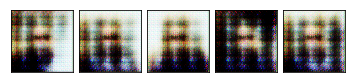

--- EPOCH 45/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.89it/s]
Discriminator loss: 0.03776854210916687
Generator loss:     6.331651042489445


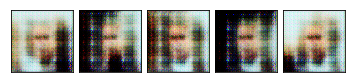

--- EPOCH 46/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.93it/s]
Discriminator loss: 0.11624074584859259
Generator loss:     7.380728777717142


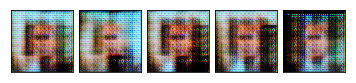

--- EPOCH 47/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.94it/s]
Discriminator loss: 0.05277440981829867
Generator loss:     8.292010167065788


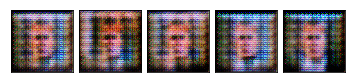

--- EPOCH 48/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.95it/s]
Discriminator loss: 0.0471189886550693
Generator loss:     9.482374051037956


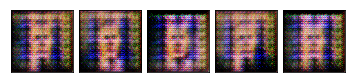

--- EPOCH 49/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.83it/s]
Discriminator loss: 0.035872211131979435
Generator loss:     8.350352679981905


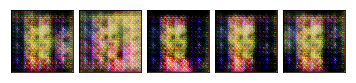

--- EPOCH 50/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.90it/s]
Discriminator loss: 0.03110201667775126
Generator loss:     8.704079656039967


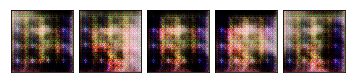

--- EPOCH 51/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.33it/s]
Discriminator loss: 0.048279769718647
Generator loss:     8.926283359527588


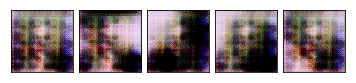

--- EPOCH 52/100 ---
100%|██████████| 17/17 [00:02<00:00,  5.89it/s]
Discriminator loss: 0.06568676112767528
Generator loss:     7.856987672693589


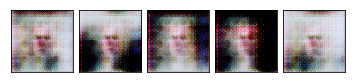

--- EPOCH 53/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.09it/s]
Discriminator loss: 0.06847464731510948
Generator loss:     8.601168323965634


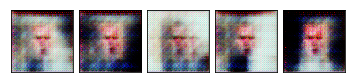

--- EPOCH 54/100 ---
100%|██████████| 17/17 [00:03<00:00,  5.41it/s]
Discriminator loss: 6.923758808304282e-05
Generator loss:     9.61361702750711


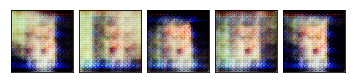

--- EPOCH 55/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.77it/s]
Discriminator loss: 0.05586788899210446
Generator loss:     7.982862500583424


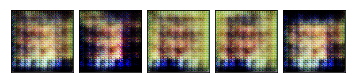

--- EPOCH 56/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.93it/s]
Discriminator loss: -0.007635623983600561
Generator loss:     10.105951898238239


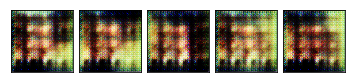

--- EPOCH 57/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.95it/s]
Discriminator loss: 0.07375726602314149
Generator loss:     10.171143279356116


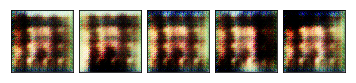

--- EPOCH 58/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.57it/s]
Discriminator loss: 0.04507555440068245
Generator loss:     10.842181121601778


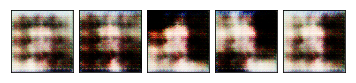

--- EPOCH 59/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.85it/s]
Discriminator loss: 0.03125573552268393
Generator loss:     7.6863525054034065


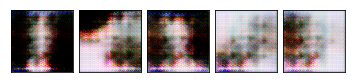

--- EPOCH 60/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.98it/s]
Discriminator loss: 0.055496521294116974
Generator loss:     8.574601902681238


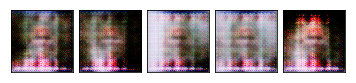

--- EPOCH 61/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.95it/s]
Discriminator loss: 0.046205444370999056
Generator loss:     9.097960780648624


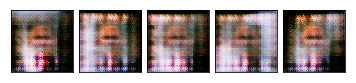

--- EPOCH 62/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.02it/s]
Discriminator loss: 0.039353899000322115
Generator loss:     8.0712890625


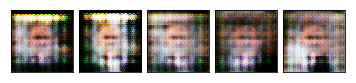

--- EPOCH 63/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.02it/s]
Discriminator loss: 0.16292337525416822
Generator loss:     10.628312601762659


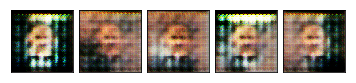

--- EPOCH 64/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.04it/s]
Discriminator loss: 0.1091403095599483
Generator loss:     8.322873648475198


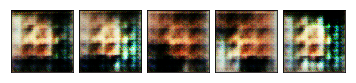

--- EPOCH 65/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.29it/s]
Discriminator loss: 0.13298627558876486
Generator loss:     7.960728757521686


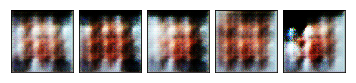

--- EPOCH 66/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.98it/s]
Discriminator loss: 0.05984142072060529
Generator loss:     7.8465894811293655


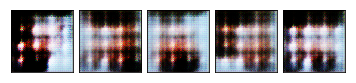

--- EPOCH 67/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.01it/s]
Discriminator loss: 0.04595970315858722
Generator loss:     7.343821301179774


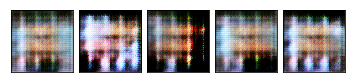

--- EPOCH 68/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.02it/s]
Discriminator loss: 0.08334050305625972
Generator loss:     7.231448706458597


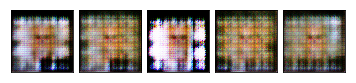

--- EPOCH 69/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.96it/s]
Discriminator loss: 0.06705126747050706
Generator loss:     7.118734864627614


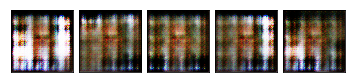

--- EPOCH 70/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.13it/s]
Discriminator loss: 0.074091966757003
Generator loss:     7.548316983615651


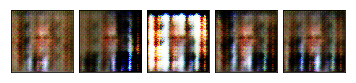

--- EPOCH 71/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.52it/s]
Discriminator loss: 0.040790695313583404
Generator loss:     7.775340472950655


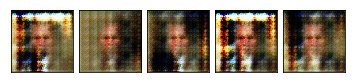

--- EPOCH 72/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.94it/s]
Discriminator loss: 0.0667124490308411
Generator loss:     10.641118806951186


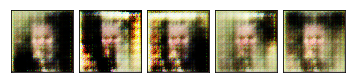

--- EPOCH 73/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.08it/s]
Discriminator loss: 0.027173008331481147
Generator loss:     8.407870517057532


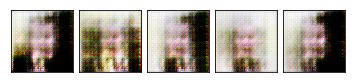

--- EPOCH 74/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.99it/s]
Discriminator loss: 0.035073784015634484
Generator loss:     8.8666210455053


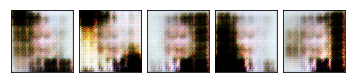

--- EPOCH 75/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.08it/s]
Discriminator loss: 0.19703516933847876
Generator loss:     8.632668411030489


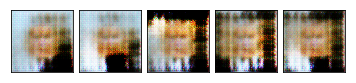

--- EPOCH 76/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.05it/s]
Discriminator loss: 0.05497694935868768
Generator loss:     8.58880864872652


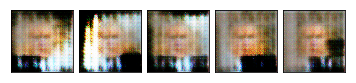

--- EPOCH 77/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.98it/s]
Discriminator loss: 0.13147956395850463
Generator loss:     6.146691799163818


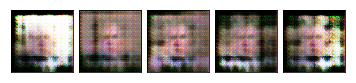

--- EPOCH 78/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.34it/s]
Discriminator loss: 0.041795612367637014
Generator loss:     6.399632846607881


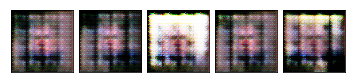

--- EPOCH 79/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.07it/s]
Discriminator loss: 0.0928485688260373
Generator loss:     6.704259872436523


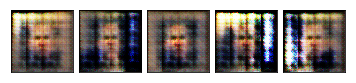

--- EPOCH 80/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.03it/s]
Discriminator loss: 0.0705031820518129
Generator loss:     7.22906426822438


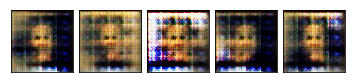

--- EPOCH 81/100 ---
100%|██████████| 17/17 [00:02<00:00,  6.94it/s]
Discriminator loss: 0.02229661395882859
Generator loss:     10.099216966068044


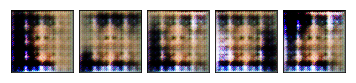

--- EPOCH 82/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.00it/s]
Discriminator loss: 0.04928890352740007
Generator loss:     8.38562651241527


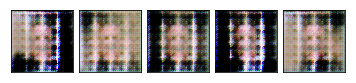

--- EPOCH 83/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.04it/s]
Discriminator loss: 0.03639476658666835
Generator loss:     8.412262720220228


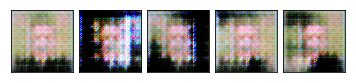

--- EPOCH 84/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.06it/s]
Discriminator loss: 0.07282999979660791
Generator loss:     8.090041637420654


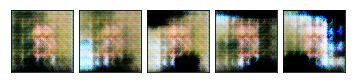

--- EPOCH 85/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.09it/s]
Discriminator loss: 0.0815587673774537
Generator loss:     7.500074779286104


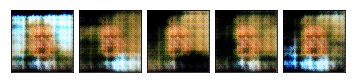

--- EPOCH 86/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.14it/s]
Discriminator loss: 0.08017913263071985
Generator loss:     7.975144680808572


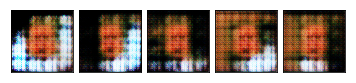

--- EPOCH 87/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.02it/s]
Discriminator loss: 0.06526555477038902
Generator loss:     8.027912280138802


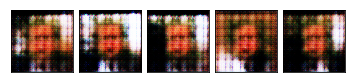

--- EPOCH 88/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.09it/s]
Discriminator loss: 0.05039529748918379
Generator loss:     6.429333770976347


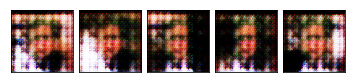

--- EPOCH 89/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.10it/s]
Discriminator loss: 0.06705110465340755
Generator loss:     7.627113594728358


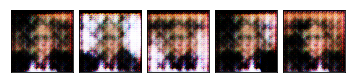

--- EPOCH 90/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.04it/s]
Discriminator loss: 0.03783460432553992
Generator loss:     7.448790213640998


--- EPOCH 91/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.11it/s]
Discriminator loss: 0.09809179647880442
Generator loss:     7.082945935866412


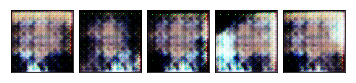

--- EPOCH 92/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.19it/s]
Discriminator loss: 0.06208826831596739
Generator loss:     8.300839087542366


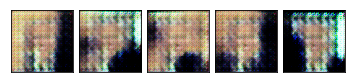

--- EPOCH 93/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.21it/s]
Discriminator loss: 0.0682477343498784
Generator loss:     10.665519265567555


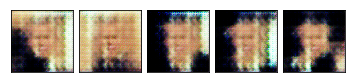

--- EPOCH 94/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.11it/s]
Discriminator loss: 0.12193802503101966
Generator loss:     8.762270983527689


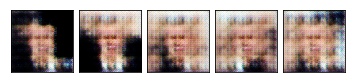

--- EPOCH 95/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.18it/s]
Discriminator loss: 0.06713681032552439
Generator loss:     9.409908378825468


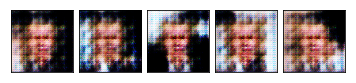

--- EPOCH 96/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.04it/s]
Discriminator loss: 0.09465335194459733
Generator loss:     9.02462875141817


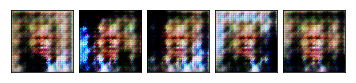

--- EPOCH 97/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.12it/s]
Discriminator loss: 0.06458752536598374
Generator loss:     9.336483254152185


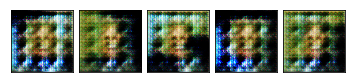

--- EPOCH 98/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.04it/s]
Discriminator loss: 0.01696797799976433
Generator loss:     9.13359375560985


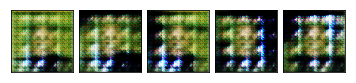

--- EPOCH 99/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.06it/s]
Discriminator loss: 0.0429774059311432
Generator loss:     9.332337631898767


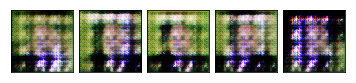

--- EPOCH 100/100 ---
100%|██████████| 17/17 [00:02<00:00,  7.12it/s]
Discriminator loss: 0.04851600349716404
Generator loss:     10.208253327537985


In [43]:
import IPython.display
import tqdm
from hw3.gan import train_batch

num_epochs = 100

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    num_epochs = 0
    gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device)
    checkpoint_file = checkpoint_file_final

for epoch_idx in range(num_epochs):
    # We'll accumulate batch losses and show an average once per epoch.
    dsc_losses = []
    gen_losses = []
    print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')
    
    with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
        for batch_idx, (x_data, _) in enumerate(dl_train):
            x_data = x_data.to(device)
            dsc_loss, gen_loss = train_batch(
                dsc, gen,
                dsc_loss_fn, gen_loss_fn,
                dsc_optimizer, gen_optimizer,
                x_data)
            dsc_losses.append(dsc_loss)
            gen_losses.append(gen_loss)
            pbar.update()

    dsc_avg_loss, gen_avg_loss = np.mean(dsc_losses), np.mean(gen_losses)
    print(f'Discriminator loss: {dsc_avg_loss}')
    print(f'Generator loss:     {gen_avg_loss}')
        
    samples = gen.sample(5, with_grad=False)
    fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
    IPython.display.display(fig)
    plt.close(fig)


*** Images Generated from best model:


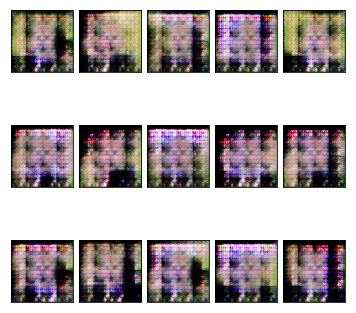

In [44]:
# Plot images from best or last model
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')
samples = gen.sample(n=15, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(6,6))

## Questions
<a id=part3_8></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw3/answers.py`.

In [ ]:
from cs236605.answers import display_answer
import hw3.answers

### Question 1

Explain in detail why during training we sometimes need to maintain gradients when sampling from the GAN,
and other times we don't. When are they maintained and why? When are they discarded and why?

In [ ]:
display_answer(hw3.answers.part3_q1)

### Question 2

1. When training a GAN to generate images, should we decide to stop training solely based on the fact that  the Generator loss is below some threshold?
Why or why not?

2. What does it mean if the discriminator loss remains at a constant value while the generator loss decreases?

In [ ]:
display_answer(hw3.answers.part3_q2)

### Question 3

Compare the results you got when generating images with the VAE to the GAN results.
What's the main difference and what's causing it?

In [ ]:
display_answer(hw3.answers.part3_q3)